In [11]:
# wind_vector.py
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from Caulimate.Utils.Visualization import plot_causal_graph, quick_map
from Caulimate.Utils.Tools import recover_coordinates


/home/minghao.fu/.conda/envs/minghao_env/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/minghao.fu/.conda/envs/minghao_env/lib/python3.12/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return se

<Figure size 1400x600 with 0 Axes>

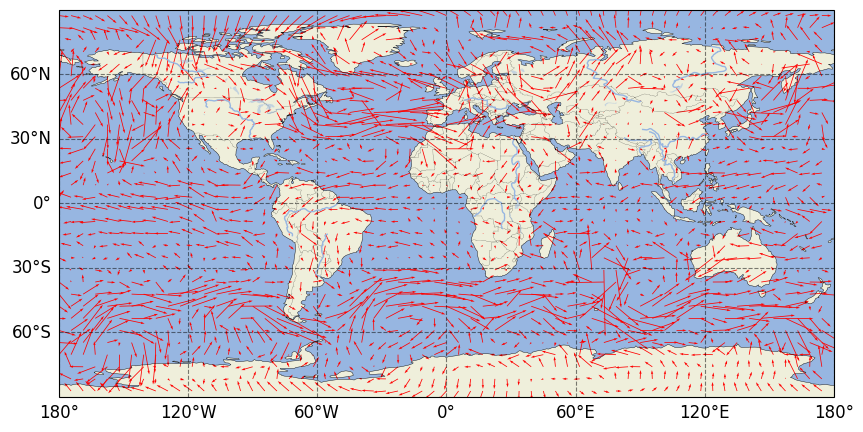

In [2]:

u = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/u_component_of_wind/*.nc', combine='by_coords')
v = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/v_component_of_wind/*.nc', combine='by_coords')

u = recover_coordinates(u)
v = recover_coordinates(v)

idx = 1000
v_slice = v.isel(time=idx).sel(level=850)['v']
u_slice = u.isel(time=idx).sel(level=850)['u']

lon = u_slice.coords['lon']
lat = u_slice.coords['lat']

# Plotting
plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
fig, ax = quick_map()

plt.quiver(lon, lat, u_slice, v_slice, scale=500, color='red', width=0.001)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


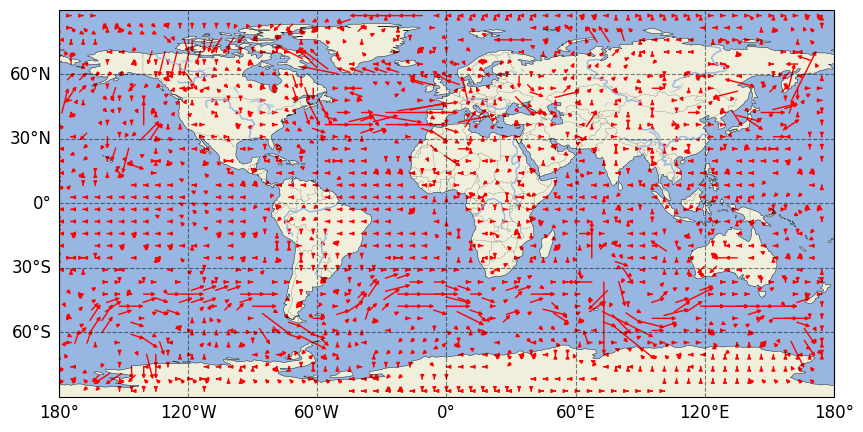

In [3]:
import numpy as np


def create_adjacency_matrix(u_slice, v_slice, lon, lat):
    n_lat, n_lon = u_slice.shape
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Flatten the arrays for easier handling
    lon_flat = lon_grid.flatten()
    lat_flat = lat_grid.flatten()
    u_flat = u_slice.flatten()
    v_flat = v_slice.flatten()
    total_points = len(lon_flat)

    # Initialize the adjacency matrix
    adj_matrix = np.zeros((total_points, total_points))

    # Compute endpoints based on the u and v vectors
    endpoint_lons = lon_flat + u_flat
    endpoint_lats = lat_flat + v_flat

    # Determine the nearest grid point for each endpoint
    for i in range(total_points):
        #lon_dis = [min(a, b) for a, b in zip(np.abs(endpoint_lons[i] - lon_flat), 360 - np.abs(endpoint_lons[i] - lon_flat))]
        #lat_dis = [min(a, b) for a, b in zip(np.abs(endpoint_lats[i] - lat_flat), 180 - np.abs(endpoint_lats[i] - lat_flat))]
        distances = np.sqrt((endpoint_lons[i] - lon_flat)**2 + (endpoint_lats[i] - lat_flat)**2)
        distances[i] = np.inf
        #distances = np.sqrt([a + b for a, b in zip([pow(x, 2) for x in lon_dis], [pow(x, 2) for x in lat_dis])])
        nearest_point_index = np.argmin(distances)
        if distances[nearest_point_index] < np.inf:  # Optionally set a maximum distance threshold
            adj_matrix[i, nearest_point_index] = np.sqrt(u_flat[i]**2 + v_flat[i]**2)

    return adj_matrix


# v_slice = v.isel(time=idx).sel(level=850)['v']
# u_slice = u.isel(time=idx).sel(level=850)['u']
adj_matrix = create_adjacency_matrix(u_slice.values, v_slice.values, lon, lat)
lon_grid, lat_grid = np.meshgrid(lon, lat)
coords = np.stack((lat_grid, lon_grid), axis=-1).reshape(-1, 2)
fig, ax = quick_map()
plot_causal_graph(coords.reshape(-1, 2), adj_matrix, ax=ax, node_size=0, plot_node_index=False)


In [4]:
lon_grid, lat_grid = np.meshgrid(lon, lat)
coords = np.stack((lat_grid, lon_grid), axis=-1)
coords.reshape(-1, 2)

array([[ -87.1875, -180.    ],
       [ -87.1875, -174.375 ],
       [ -87.1875, -168.75  ],
       ...,
       [  87.1875,  163.125 ],
       [  87.1875,  168.75  ],
       [  87.1875,  174.375 ]])

<Figure size 1400x600 with 0 Axes>

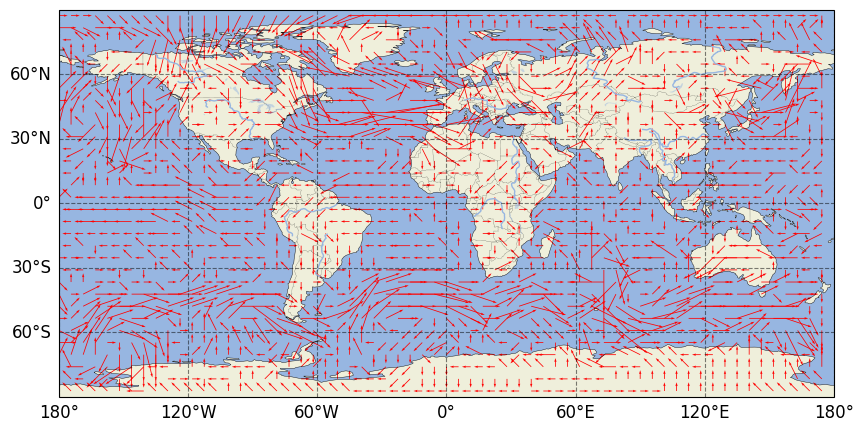

In [5]:

def reconstruct_uv_slices(adj_matrix, lat, lon):
    n_lat, n_lon = len(lat), len(lon)
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Flatten the grids for easier indexing
    lon_flat = lon_grid.flatten()
    lat_flat = lat_grid.flatten()

    # Initialize u_slice and v_slice
    u_slice = np.zeros_like(lon_grid)
    v_slice = np.zeros_like(lat_grid)

    # Iterate through each grid point in the adjacency matrix
    for i in range(n_lat * n_lon):
        # Get the index of the maximum connection
        j = np.argmax(adj_matrix[i, :])
        if adj_matrix[i, j] > 0:  # Check if there is a connection
            # Calculate the vector components
            u_slice.flat[i] = lon_flat[j] - lon_flat[i]
            v_slice.flat[i] = lat_flat[j] - lat_flat[i]
    return u_slice, v_slice

u_slice_, v_slice_ = reconstruct_uv_slices(adj_matrix, lat, lon)
center = 0
plt.figure(figsize=(14, 6))
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=center))
# ax.coastlines()

fig, ax = quick_map()

adj_matrix = adj_matrix / np.max(adj_matrix)

plt.quiver(lon - center, lat, u_slice_, v_slice_, scale=500, color='red', width=0.001)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

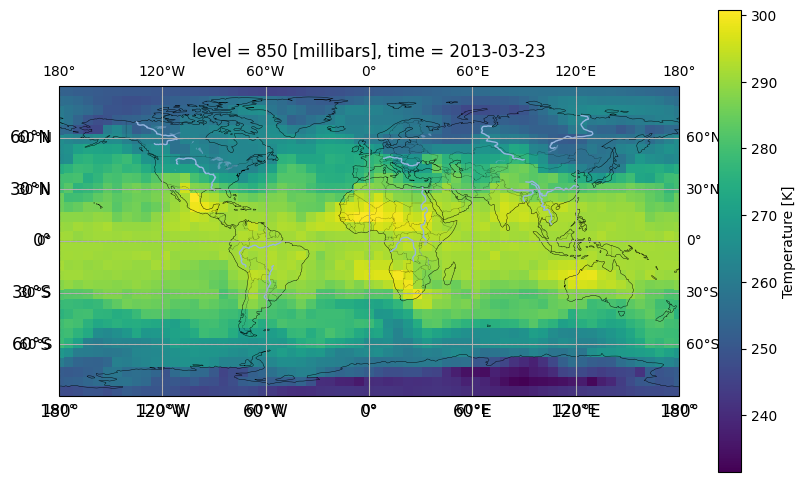

In [13]:
z500 = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/temperature_850/*.nc', combine='by_coords')
data = z500.t.isel(time=300000)

# Plotting
fig, ax = quick_map()
#ax.set_extent([-100, 20, 0, 70])

# Plot the data
ax.gridlines(draw_labels=True)
data.plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat')


In [9]:
data_dns = data.coarsen(lat=2, lon=2, boundary='trim').mean()
data_dns.plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat')